<a href="https://colab.research.google.com/github/smrithisriram/Traffic-Flow-Forecasting/blob/main/Traffic_Flow_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Modules

In [ ]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
pip install --upgrade keras

In [ ]:
import pandas as pd
import glob
import math
import numpy as np
import numpy.linalg as la
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Attention, Concatenate, Layer, RepeatVector, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import tanh, sigmoid
from tensorflow.keras.layers import Attention, Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras import ops
import datetime
import time
import scipy.sparse as sp
from dateutil.parser import parse
from tensorflow.python.platform import tf_logging as logging

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os

# os.makedirs('/content/drive/MyDrive/new/data/flow/monthly_csv', exist_ok=True)
# os.makedirs('/content/drive/MyDrive/new/data/weather', exist_ok=True)
# os.makedirs('/content/drive/MyDrive/new/data/incident', exist_ok=True)

#Loading Traffic Data

In [ ]:
# List all files matching the pattern in the specified directory
file_list = glob.glob('/content/drive/MyDrive/new/data/flow/Copy of d07_text_station_5min_2024_02_*.txt')

# Initialize an empty list to store processed dataframes
all_dataframes = []

# Loop through each file and process the data
for file_path in file_list:
    # Read the data for each day
    traffic_data = pd.read_csv(file_path, header=None)
    traffic_data = traffic_data[[0,1,5,9,10,11]]
    traffic_data.columns = ['timestamp', 'vds', 'lane type', 'total flow', 'avg occupancy', 'avg speed']
    traffic_data = traffic_data.loc[traffic_data['lane type'] == "ML"]
    traffic_data = traffic_data.reset_index()
    traffic_data = traffic_data[['timestamp', 'vds', 'total flow', 'avg occupancy', 'avg speed']]

    pivoted_df = traffic_data.pivot(index='timestamp', columns='vds', values=['total flow', 'avg occupancy', 'avg speed'])
    pivoted_df.columns = ['_'.join(map(str, col)) for col in pivoted_df.columns]
    pivoted_df.reset_index(inplace=True)

    required_vds = [763299, 774703, 716494, 763309, 716491, 763314, 763621, 716485, 766988, 716481,
                    766337, 760167, 716427, 716431, 716433, 776826, 760187, 760196, 716440, 716442,
                    760226, 760236, 716449, 718155, 767868, 716456, 760283, 716460, 760301, 760315,
                    716466, 760330, 716470, 764001, 717848, 717867, 717862, 717859, 716776, 773737,
                    717843, 717842, 717838, 717833, 773724, 737504, 773711, 717832, 718258, 716660,
                    766493, 774327, 771938, 718253, 771925, 717731, 771914, 718249, 771897, 718247,
                    771879, 771864, 718245, 718242, 718243, 718240, 718238, 718235, 771846, 717710,
                    718232, 718229, 716626, 718226, 718223, 718221, 717699, 717697, 771825, 717367,
                    717369, 717373, 717379, 717381, 717383, 717387, 717390, 717396, 716296, 717402,
                    717406, 765467, 718326, 717418, 717420, 768898, 716312, 716313, 761761, 717972,
                    717975, 717970, 716847, 717963, 717960]

    required_columns = ['timestamp'] + [f'total flow_{vds}' for vds in required_vds] + \
                       [f'avg occupancy_{vds}' for vds in required_vds] + \
                       [f'avg speed_{vds}' for vds in required_vds]

    filtered_df = pivoted_df[required_columns]

    all_dataframes.append(filtered_df)

In [ ]:
# Concatenate all dataframes in the list based on timestamp order 761851
final_df = pd.concat(all_dataframes)

# Convert 'timestamp' column to datetime format
final_df['timestamp'] = pd.to_datetime(final_df['timestamp'])

# Extract date, hour, and minute features
final_df['date'] = final_df['timestamp'].dt.date
final_df['hour'] = final_df['timestamp'].dt.hour
final_df['minute'] = final_df['timestamp'].dt.minute

# Sort the dataframe based on the 'timestamp' column
final_df.sort_values(by='timestamp', inplace=True)

# Reset the index after sorting
final_df.reset_index(drop=True, inplace=True)

# Display the final concatenated dataframe
final_df

In [ ]:
# Save the processed dataframe to a CSV file for the month
month_directory = f'/content/drive/MyDrive/new/data/flow/monthly_csv'
file_name = f'{month_directory}/february.csv'
final_df.to_csv(file_name, index=False)

#Combining Traffic Data

In [ ]:
# Load CSV files for each month
august_df = pd.read_csv('/content/drive/MyDrive/new/data/flow/monthly_csv/august.csv')
september_df = pd.read_csv('/content/drive/MyDrive/new/data/flow/monthly_csv/september.csv')
october_df = pd.read_csv('/content/drive/MyDrive/new/data/flow/monthly_csv/october.csv')
november_df = pd.read_csv('/content/drive/MyDrive/new/data/flow/monthly_csv/november.csv')
january_df = pd.read_csv('/content/drive/MyDrive/new/data/flow/monthly_csv/january.csv')
february_df = pd.read_csv('/content/drive/MyDrive/new/data/flow/monthly_csv/february.csv')

# Concatenate dataframes in the desired order
combined_df = pd.concat([august_df, september_df, october_df, november_df, january_df, february_df])

# Reset the index after sorting
combined_df.reset_index(drop=True, inplace=True)

# Save the final concatenated dataframe to a CSV file
combined_df.to_csv('/content/drive/MyDrive/new/data/flow/concatenated_data.csv', index=False)

# Display the final concatenated dataframe
combined_df

,timestamp,total flow_763299,total flow_774703,total flow_716494,total flow_763309,total flow_716491,total flow_763314,total flow_763621,total flow_716485,total flow_766988,...,avg speed_761761,avg speed_717972,avg speed_717975,avg speed_717970,avg speed_716847,avg speed_717963,avg speed_717960,date,hour,minute
0,2023-08-01 00:00:00,16.0,16.0,136.0,135.0,119.0,135.0,94.0,119.0,16.0,...,67.9,67.6,69.7,67.2,69.1,69.0,61.7,2023-08-01,0,0
1,2023-08-01 00:05:00,16.0,16.0,132.0,133.0,115.0,133.0,87.0,116.0,16.0,...,66.1,65.9,66.0,67.1,68.7,70.7,65.5,2023-08-01,0,5
2,2023-08-01 00:10:00,15.0,15.0,132.0,133.0,115.0,133.0,75.0,116.0,15.0,...,64.1,63.6,64.3,65.5,68.5,68.2,62.6,2023-08-01,0,10
3,2023-08-01 00:15:00,15.0,15.0,127.0,128.0,111.0,128.0,57.0,113.0,15.0,...,63.4,63.6,61.3,65.4,68.5,65.3,59.1,2023-08-01,0,15
4,2023-08-01 00:20:00,14.0,14.0,121.0,123.0,106.0,123.0,65.0,107.0,14.0,...,64.8,64.6,63.6,67.0,68.2,64.3,57.4,2023-08-01,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,2024-02-29 23:35:00,29.0,29.0,203.0,201.0,177.0,201.0,201.0,177.0,29.0,...,65.2,65.6,68.0,69.2,68.5,68.5,65.2,2024-02-29,23,35
52412,2024-02-29 23:40:00,29.0,29.0,198.0,197.0,173.0,197.0,197.0,174.0,29.0,...,65.2,67.2,68.2,69.3,68.6,68.6,65.2,2024-02-29,23,40
52413,2024-02-29 23:45:00,27.0,27.0,190.0,191.0,166.0,191.0,191.0,165.0,27.0,...,65.2,68.1,68.1,69.2,68.5,68.5,65.2,2024-02-29,23,45
52414,2024-02-29 23:50:00,25.0,25.0,182.0,182.0,159.0,182.0,182.0,159.0,25.0,...,65.2,67.7,68.2,69.2,68.5,68.5,65.2,2024-02-29,23,50


#Topology Representation & Adjacency Matrix Generation

In [ ]:
combined_df = pd.read_csv('/content/drive/MyDrive/concatenated_data.csv')

In [ ]:
#left nodes
nodes_110s = [763299, 774703, 716494, 763309, 716491, 763314, 763621, 716485, 766988, 716481, 766337] # 10 * 2 =20
#top nodes
nodes_105e = [760167, 716427, 716431, 716433, 776826, 760187, 760196, 716440, 716442, 760226, 760236, 716449, 718155, 767868, 716456, 760283, 716460, 760301, 760315, 716466, 760330, 716470] # 21 * 2 = 42
#right nodes
nodes_605s = [764001, 717848, 717867, 717862, 717859, 716776, 773737, 717843, 717842, 717838, 717833, 773724, 737504, 773711, 717832] # 1202537, 1219560, 1219710] 14 * 2 = 28
#bottom nodes
nodes_405s = [718258, 716660, 766493, 774327, 771938, 718253, 771925, 717731, 771914, 718249, 771897, 718247, 771879, 771864, 718245, 718242, 718243, 718240, 718238, 718235, 771846, 717710, 718232, 718229, 716626, 718226, 718223, 718221, 717699, 717697, 771825] #30 * 2=60
#horizontal nodes
nodes_sr91e = [717367, 717369, 717373, 717379, 717381, 717383, 717387, 717390, 717396, 716296, 717402, 717406, 765467, 718326, 717418, 717420, 768898, 716312, 716313] # 18 * 2 = 36
#vertical nodes
nodes_710s = [761761, 717972, 717975, 717970, 716847, 717963, 717960] #6*2 = 12

nodes = nodes_110s+nodes_105e+nodes_605s+nodes_405s+nodes_sr91e+nodes_710s

print(len(nodes_110s),len(nodes_105e),len(nodes_605s),len(nodes_405s),len(nodes_sr91e),len(nodes_710s),len(nodes))

11 22 15 31 19 7 105


In [ ]:
# List of connected VDS stations
connected_vds = [(763299, 760167), (766337, 718258), (716470, 764001), (771825, 717832), (718155, 761761), (717960, 771879), (766988, 717367), (716313, 716776), (717390, 716847), (717396, 716847)]

# Number of VDS stations
num_vds = 105

# Initialize adjacency matrix with zeros
adjacency_matrix = np.zeros((num_vds, num_vds))

# Create a mapping dictionary to map VDS IDs to matrix indices
vds_to_index = {vds_id: index for index, vds_id in enumerate(nodes)}

# Populate adjacency matrix based on connected VDS stations
for vds1, vds2 in connected_vds:
    index1 = vds_to_index[vds1]
    index2 = vds_to_index[vds2]
    adjacency_matrix[index1, index2] = 1
    adjacency_matrix[index2, index1] = 1

for nodes_list in [nodes_110s, nodes_105e, nodes_605s, nodes_405s, nodes_sr91e, nodes_710s]:
    pairs = list(zip(nodes_list, nodes_list[1:]))
    for vds1, vds2 in pairs:
      index1 = vds_to_index[vds1]
      index2 = vds_to_index[vds2]
      adjacency_matrix[index1, index2] = 1
      adjacency_matrix[index2, index1] = 1

# Count the number of ones in the adjacency matrix
num_ones = np.count_nonzero(adjacency_matrix)

# Print the number of ones
print("Number of ones in the adjacency matrix:", num_ones)

# Print adjacency matrix
print(adjacency_matrix)

Number of ones in the adjacency matrix: 218
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
# Create a mapping dictionary to map old column headers to new headers based on vds_to_index mapping
column_mapping = {}
for old_col in combined_df.columns:
    split_result = old_col.split("_")
    if len(split_result) > 1:
        vds_id = int(split_result[1])
        if old_col.startswith('total flow_'):
            column_mapping[old_col] = f'total flow_{vds_to_index[vds_id]}'
        elif old_col.startswith('avg occupancy_'):
            column_mapping[old_col] = f'avg occupancy_{vds_to_index[vds_id]}'
        elif old_col.startswith('avg speed_'):
            column_mapping[old_col] = f'avg speed_{vds_to_index[vds_id]}'
    else:
        column_mapping[old_col] = old_col

# Rename columns using the mapping dictionary
combined_df = combined_df.rename(columns=column_mapping)

# Print the DataFrame with updated column headers
combined_df

,timestamp,total flow_0,total flow_1,total flow_2,total flow_3,total flow_4,total flow_5,total flow_6,total flow_7,total flow_8,...,avg speed_98,avg speed_99,avg speed_100,avg speed_101,avg speed_102,avg speed_103,avg speed_104,date,hour,minute
0,2023-08-01 00:00:00,16.0,16.0,136.0,135.0,119.0,135.0,94.0,119.0,16.0,...,67.9,67.6,69.7,67.2,69.1,69.0,61.7,2023-08-01,0,0
1,2023-08-01 00:05:00,16.0,16.0,132.0,133.0,115.0,133.0,87.0,116.0,16.0,...,66.1,65.9,66.0,67.1,68.7,70.7,65.5,2023-08-01,0,5
2,2023-08-01 00:10:00,15.0,15.0,132.0,133.0,115.0,133.0,75.0,116.0,15.0,...,64.1,63.6,64.3,65.5,68.5,68.2,62.6,2023-08-01,0,10
3,2023-08-01 00:15:00,15.0,15.0,127.0,128.0,111.0,128.0,57.0,113.0,15.0,...,63.4,63.6,61.3,65.4,68.5,65.3,59.1,2023-08-01,0,15
4,2023-08-01 00:20:00,14.0,14.0,121.0,123.0,106.0,123.0,65.0,107.0,14.0,...,64.8,64.6,63.6,67.0,68.2,64.3,57.4,2023-08-01,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,2024-02-29 23:35:00,29.0,29.0,203.0,201.0,177.0,201.0,201.0,177.0,29.0,...,65.2,65.6,68.0,69.2,68.5,68.5,65.2,2024-02-29,23,35
52412,2024-02-29 23:40:00,29.0,29.0,198.0,197.0,173.0,197.0,197.0,174.0,29.0,...,65.2,67.2,68.2,69.3,68.6,68.6,65.2,2024-02-29,23,40
52413,2024-02-29 23:45:00,27.0,27.0,190.0,191.0,166.0,191.0,191.0,165.0,27.0,...,65.2,68.1,68.1,69.2,68.5,68.5,65.2,2024-02-29,23,45
52414,2024-02-29 23:50:00,25.0,25.0,182.0,182.0,159.0,182.0,182.0,159.0,25.0,...,65.2,67.7,68.2,69.2,68.5,68.5,65.2,2024-02-29,23,50


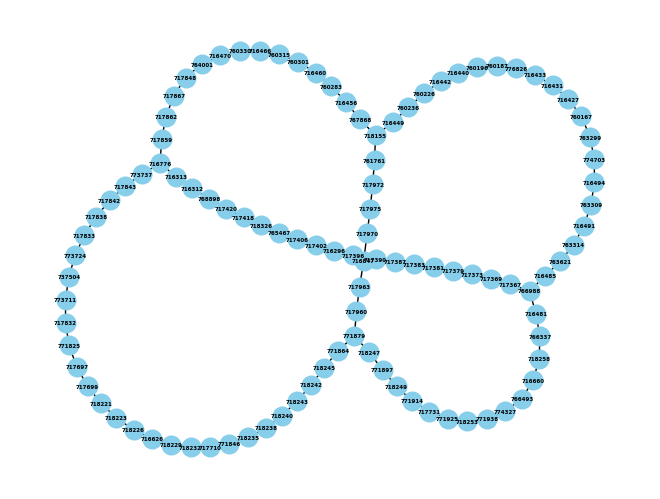

In [ ]:
# Create a graph and add nodes
G = nx.Graph()

G.add_nodes_from(nodes)

# Add bidirectional edges between consecutive pairs in each list
for nodes_list in [nodes_110s, nodes_105e, nodes_605s, nodes_405s, nodes_sr91e, nodes_710s]:
    G.add_edges_from(zip(nodes_list, nodes_list[1:]))
    G.add_edges_from(zip(nodes_list[1:], nodes_list))

for edge in connected_vds:
    G.add_edges_from([(edge[0], edge[1]), (edge[1], edge[0])])

# Plot the graph
pos = nx.kamada_kawai_layout(G)  # Choose a layout algorithm
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='skyblue', node_size=180, font_size=4)
plt.show()

#Preprocessing - Traffic Data

In [ ]:
features_columns = ['total flow', 'avg occupancy', 'avg speed']
nodes = 105  # Number of nodes (VDSs)
features_per_node = len(features_columns)

In [ ]:
# Select traffic feature columns
traffic_df = combined_df.drop(['timestamp', 'date', 'hour', 'minute'], axis=1)
traffic_df

,total flow_0,total flow_1,total flow_2,total flow_3,total flow_4,total flow_5,total flow_6,total flow_7,total flow_8,total flow_9,...,avg speed_95,avg speed_96,avg speed_97,avg speed_98,avg speed_99,avg speed_100,avg speed_101,avg speed_102,avg speed_103,avg speed_104
0,16.0,16.0,136.0,135.0,119.0,135.0,94.0,119.0,16.0,16.0,...,72.6,65.3,69.2,67.9,67.6,69.7,67.2,69.1,69.0,61.7
1,16.0,16.0,132.0,133.0,115.0,133.0,87.0,116.0,16.0,16.0,...,72.3,65.7,68.8,66.1,65.9,66.0,67.1,68.7,70.7,65.5
2,15.0,15.0,132.0,133.0,115.0,133.0,75.0,116.0,15.0,15.0,...,72.1,65.6,68.6,64.1,63.6,64.3,65.5,68.5,68.2,62.6
3,15.0,15.0,127.0,128.0,111.0,128.0,57.0,113.0,15.0,15.0,...,72.7,64.5,68.5,63.4,63.6,61.3,65.4,68.5,65.3,59.1
4,14.0,14.0,121.0,123.0,106.0,123.0,65.0,107.0,14.0,14.0,...,72.7,62.9,68.3,64.8,64.6,63.6,67.0,68.2,64.3,57.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,29.0,29.0,203.0,201.0,177.0,201.0,201.0,177.0,29.0,30.0,...,71.9,64.7,66.9,65.2,65.6,68.0,69.2,68.5,68.5,65.2
52412,29.0,29.0,198.0,197.0,173.0,197.0,197.0,174.0,29.0,30.0,...,72.1,62.2,61.2,65.2,67.2,68.2,69.3,68.6,68.6,65.2
52413,27.0,27.0,190.0,191.0,166.0,191.0,191.0,165.0,27.0,27.0,...,72.5,61.8,54.2,65.2,68.1,68.1,69.2,68.5,68.5,65.2
52414,25.0,25.0,182.0,182.0,159.0,182.0,182.0,159.0,25.0,26.0,...,72.1,60.5,53.6,65.2,67.7,68.2,69.2,68.5,68.5,65.2


In [ ]:
# Normalize the traffic data using MinMax normalization
scaler = MinMaxScaler()
norm_traffic_df = scaler.fit_transform(traffic_df)
norm_traffic_df

array([[0.09302326, 0.09302326, 0.1564482 , ..., 0.9623431 , 0.90340909,
        0.82934132],
       [0.09302326, 0.09302326, 0.14799154, ..., 0.94560669, 0.92755682,
        0.88622754],
       [0.08527132, 0.08527132, 0.14799154, ..., 0.93723849, 0.89204545,
        0.84281437],
       ...,
       [0.17829457, 0.17829457, 0.27061311, ..., 0.93723849, 0.89630682,
        0.88173653],
       [0.1627907 , 0.1627907 , 0.25369979, ..., 0.93723849, 0.89630682,
        0.88173653],
       [0.14728682, 0.14728682, 0.23255814, ..., 0.93305439, 0.89488636,
        0.88173653]])

In [ ]:
# Convert data from array to dataframe
norm_traf_data = pd.DataFrame(norm_traffic_df, columns=traffic_df.columns)
norm_traf_data

,total flow_0,total flow_1,total flow_2,total flow_3,total flow_4,total flow_5,total flow_6,total flow_7,total flow_8,total flow_9,...,avg speed_95,avg speed_96,avg speed_97,avg speed_98,avg speed_99,avg speed_100,avg speed_101,avg speed_102,avg speed_103,avg speed_104
0,0.093023,0.093023,0.156448,0.152866,0.157385,0.152866,0.147567,0.154589,0.093023,0.093750,...,0.856618,0.877483,0.891484,0.889680,0.894049,0.873984,0.853990,0.962343,0.903409,0.829341
1,0.093023,0.093023,0.147992,0.148620,0.147700,0.148620,0.136578,0.147343,0.093023,0.093750,...,0.851103,0.884106,0.885989,0.857651,0.869376,0.823848,0.852292,0.945607,0.927557,0.886228
2,0.085271,0.085271,0.147992,0.148620,0.147700,0.148620,0.117739,0.147343,0.085271,0.085938,...,0.847426,0.882450,0.883242,0.822064,0.835994,0.800813,0.825127,0.937238,0.892045,0.842814
3,0.085271,0.085271,0.137421,0.138004,0.138015,0.138004,0.089482,0.140097,0.085271,0.085938,...,0.858456,0.864238,0.881868,0.809609,0.835994,0.760163,0.823430,0.937238,0.850852,0.790419
4,0.077519,0.077519,0.124736,0.127389,0.125908,0.127389,0.102041,0.125604,0.077519,0.078125,...,0.858456,0.837748,0.879121,0.834520,0.850508,0.791328,0.850594,0.924686,0.836648,0.764970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,0.193798,0.193798,0.298097,0.292994,0.297821,0.292994,0.315542,0.294686,0.193798,0.203125,...,0.843750,0.867550,0.859890,0.841637,0.865022,0.850949,0.887946,0.937238,0.896307,0.881737
52412,0.193798,0.193798,0.287526,0.284501,0.288136,0.284501,0.309262,0.287440,0.193798,0.203125,...,0.847426,0.826159,0.781593,0.841637,0.888244,0.853659,0.889643,0.941423,0.897727,0.881737
52413,0.178295,0.178295,0.270613,0.271762,0.271186,0.271762,0.299843,0.265700,0.178295,0.179688,...,0.854779,0.819536,0.685440,0.841637,0.901306,0.852304,0.887946,0.937238,0.896307,0.881737
52414,0.162791,0.162791,0.253700,0.252654,0.254237,0.252654,0.285714,0.251208,0.162791,0.171875,...,0.847426,0.798013,0.677198,0.841637,0.895501,0.853659,0.887946,0.937238,0.896307,0.881737


In [ ]:
norm_traffic_df = norm_traffic_df.reshape(-1, 105, 3)
norm_traffic_df.shape

(52416, 105, 3)

In [ ]:
norm_traffic_df

array([[[0.09302326, 0.09302326, 0.1564482 ],
        [0.15286624, 0.15738499, 0.15286624],
        [0.14756672, 0.15458937, 0.09302326],
        ...,
        [0.87748344, 0.89148352, 0.88967972],
        [0.89404935, 0.87398374, 0.85398981],
        [0.9623431 , 0.90340909, 0.82934132]],

       [[0.09302326, 0.09302326, 0.14799154],
        [0.14861996, 0.14769976, 0.14861996],
        [0.13657771, 0.147343  , 0.09302326],
        ...,
        [0.88410596, 0.88598901, 0.85765125],
        [0.86937591, 0.82384824, 0.85229202],
        [0.94560669, 0.92755682, 0.88622754]],

       [[0.08527132, 0.08527132, 0.14799154],
        [0.14861996, 0.14769976, 0.14861996],
        [0.1177394 , 0.147343  , 0.08527132],
        ...,
        [0.88245033, 0.88324176, 0.82206406],
        [0.83599419, 0.80081301, 0.82512733],
        [0.93723849, 0.89204545, 0.84281437]],

       ...,

       [[0.17829457, 0.17829457, 0.27061311],
        [0.27176221, 0.27118644, 0.27176221],
        [0.29984301, 0

#Preprocessing - Weather Data

###Combining Weather Data

In [ ]:
# List all files matching the pattern in the specified directory
file_list = glob.glob('/content/drive/MyDrive/Copy of *_weather.csv')

# Initialize an empty list to store processed dataframes
all_weather = []

# Loop through each file and process the data
for file_path in file_list:
    # Read the data for each month
    weather_data = pd.read_csv(file_path)
    weather_data = weather_data.drop(weather_data.index[0])
    weather_data = weather_data[['Date_Time', 'weather_summary_set_1d']]
    all_weather.append(weather_data)

In [ ]:
# Concatenate all dataframes in the list based on timestamp
final_weather = pd.concat(all_weather)
final_weather['Date_Time'] = final_weather['Date_Time'].apply(parse)

# Convert 'timestamp' column to datetime format
final_weather['Date_Time'] = pd.to_datetime(final_weather['Date_Time'])

# Dropping null values in the dataframe
final_weather = final_weather.dropna()

# Sort the dataframe based on the 'timestamp' column
final_weather.sort_values(by='Date_Time', inplace=True)

# Renaming columns of the 'weather' dataframe
final_weather = final_weather.rename(columns={'Date_Time': 'timestamp', 'weather_summary_set_1d': 'weather desc'})
final_weather = final_weather[final_weather['timestamp'].isin(combined_df['timestamp'].unique().tolist())]

# Reset the index after sorting
final_weather.reset_index(drop=True, inplace=True)
final_weather

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
<ipython-input-18-0a8cb9eea888>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_weather.sort_values(by='Date_Time', inplace=Tru

,timestamp,weather desc
0,2023-08-01 00:00:00,clear
1,2023-08-01 00:05:00,clear
2,2023-08-01 00:10:00,clear
3,2023-08-01 00:15:00,clear
4,2023-08-01 00:20:00,clear
...,...,...
51192,2024-02-29 23:35:00,overcast
51193,2024-02-29 23:40:00,overcast
51194,2024-02-29 23:45:00,overcast
51195,2024-02-29 23:50:00,overcast


###Handling Missing Data

In [ ]:
# Adding missing timestamps from traffic data into weather data
traffic_timestamps = set(combined_df['timestamp'])
weather_timestamps = set(final_weather['timestamp'])

missing_timestamps = traffic_timestamps - weather_timestamps
missing_weather_rows = pd.DataFrame({'timestamp': list(missing_timestamps), 'weather desc': None})

# Add the missing timestamps to end of dataframe
weather_data = pd.concat([final_weather, missing_weather_rows], ignore_index=True)
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'])

# Drop duplicate timestamps
weather_data = weather_data.drop_duplicates(subset=['timestamp'])

# Sort the timestamps
weather_data.sort_values(by='timestamp', inplace=True)

# Reset index after sorting
weather_data.reset_index(drop=True, inplace=True)
weather_data

<ipython-input-19-f8e3ccb64ae3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data.sort_values(by='timestamp', inplace=True)


,timestamp,weather desc
0,2023-08-01 00:00:00,clear
1,2023-08-01 00:05:00,clear
2,2023-08-01 00:10:00,clear
3,2023-08-01 00:15:00,clear
4,2023-08-01 00:20:00,clear
...,...,...
52411,2024-02-29 23:35:00,overcast
52412,2024-02-29 23:40:00,overcast
52413,2024-02-29 23:45:00,overcast
52414,2024-02-29 23:50:00,overcast


###One Hot Encoding

In [ ]:
# Get all weather summaries from the dataframe
weathers = weather_data['weather desc'].values

climate_mapping = {
    None: -1,
    'clear': 0,
    'haze': 0,
    'thin scattered': 0,
    'scattered': 0,
    'broken': 0,
    'overcast': 0,
    'mist': 1,
    'light rain': 1,
    'thunder': 1,
    'thunderstorm': 2,
    'rain': 1,
    'thunder,light rain': 2,
    'fog': 1,
    'light rain,mist': 1,
    'rain,mist': 1,
    'heavy rain,mist': 2,
    'light rain/thunderstorm': 2,
    'thunder,heavy rain': 2,
    'heavy rain': 2,
    'heavy rain/thunderstorm': 2,
    'heavy rain,fog': 2,
    'nan': 0
}

In [ ]:
encoder = OneHotEncoder()

# Encode incidents based on severity mapping
encoded_weather = []
for weather in weathers:
    severity = climate_mapping[weather]
    encoded_weather.append([severity])

# Fit and transform the encoded incidents
encoded_data = encoder.fit_transform(encoded_weather)

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=[f'severity_{i}' for i in range(-1, 3)])
encoded_df['weather desc'] = weathers
encoded_df

,severity_-1,severity_0,severity_1,severity_2,weather desc
0,0.0,1.0,0.0,0.0,clear
1,0.0,1.0,0.0,0.0,clear
2,0.0,1.0,0.0,0.0,clear
3,0.0,1.0,0.0,0.0,clear
4,0.0,1.0,0.0,0.0,clear
...,...,...,...,...,...
52411,0.0,1.0,0.0,0.0,overcast
52412,0.0,1.0,0.0,0.0,overcast
52413,0.0,1.0,0.0,0.0,overcast
52414,0.0,1.0,0.0,0.0,overcast


In [ ]:
# Join weather and encoded data based on 'weather desc'
merged_weather = weather_data.join(encoded_df, how='inner', rsuffix=" enc")

# Drop redundant columns
merged_weather.drop(['weather desc enc'], inplace=True, axis=1)

# Find the column with the maximum value for each row
max_severity_column = merged_weather[['severity_-1', 'severity_0', 'severity_1', 'severity_2']].idxmax(axis=1)

# Extract the severity number from the column name
severity_number = max_severity_column.str.split('_').str[-1].astype(int)

# Add the severity number as a new column
merged_weather['climate severity'] = severity_number
merged_weather

,timestamp,weather desc,severity_-1,severity_0,severity_1,severity_2,climate severity
0,2023-08-01 00:00:00,clear,0.0,1.0,0.0,0.0,0
1,2023-08-01 00:05:00,clear,0.0,1.0,0.0,0.0,0
2,2023-08-01 00:10:00,clear,0.0,1.0,0.0,0.0,0
3,2023-08-01 00:15:00,clear,0.0,1.0,0.0,0.0,0
4,2023-08-01 00:20:00,clear,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...
52411,2024-02-29 23:35:00,overcast,0.0,1.0,0.0,0.0,0
52412,2024-02-29 23:40:00,overcast,0.0,1.0,0.0,0.0,0
52413,2024-02-29 23:45:00,overcast,0.0,1.0,0.0,0.0,0
52414,2024-02-29 23:50:00,overcast,0.0,1.0,0.0,0.0,0


###Interpolation Of Weather Data

In [ ]:
# Iterate through the DataFrame
for index, row in merged_weather.iterrows():
    if row['climate severity'] == -1:
        # Find the previous non-empty severity number
        prev_index = index - 1
        while prev_index >= 0 and merged_weather.loc[prev_index, 'climate severity'] == -1:
            prev_index -= 1

        # Find the next non-empty severity number
        next_index = index + 1
        while next_index < len(merged_weather) and merged_weather.loc[next_index, 'climate severity'] == -1:
            next_index += 1

        # Interpolate the severity number based on the previous and next non-empty severity numbers
        if prev_index >= 0 and next_index < len(merged_weather):
            prev_severity = merged_weather.loc[prev_index, 'climate severity']
            next_severity = merged_weather.loc[next_index, 'climate severity']

            # Perform linear interpolation
            interpolated_severity = (prev_severity + next_severity) / 2

            # Clip the interpolated severity number to the range [0, 2]
            interpolated_severity = np.clip(interpolated_severity, 0, 2)

            # Update the 'severity_number' column with the clipped interpolated severity number
            merged_weather.at[index, 'climate severity'] = interpolated_severity

In [ ]:
# Drop unnecessary columns
merged_weather.drop(['weather desc', 'severity_-1', 'severity_0', 'severity_1', 'severity_2'], inplace=True, axis=1)
merged_weather

,timestamp,climate severity
0,2023-08-01 00:00:00,0.0
1,2023-08-01 00:05:00,0.0
2,2023-08-01 00:10:00,0.0
3,2023-08-01 00:15:00,0.0
4,2023-08-01 00:20:00,0.0
...,...,...
52411,2024-02-29 23:35:00,0.0
52412,2024-02-29 23:40:00,0.0
52413,2024-02-29 23:45:00,0.0
52414,2024-02-29 23:50:00,0.0


In [ ]:
# Save the final dataframe to a CSV file
merged_weather.to_csv('/content/drive/MyDrive/new/data/weather/concatenated_weather.csv', index=False)

#Preprocessing - Incident Data

###Combining Incident Data

In [ ]:
# List all files matching the pattern in the specified directory
file_list = glob.glob('/content/drive/MyDrive/Copy of all_text_chp_incidents_month_2023_*.txt')

# Initialize an empty list to store processed dataframes
all_incident = []

# Loop through each file and process the data
for file_path in file_list:
    # Read the data for each day
    incident_data = pd.read_csv(file_path, header=None)
    incident_data = incident_data[incident_data[11] == 7.0]
    incident_data = incident_data[[3, 4, 9, 10, 14, 15, 16, 17]]
    incident_data.columns = ['timestamp', 'desc', 'latitude', 'longitude', 'fwy number', 'fwy direction', 'ca pm', 'abs pm']
    incident_data['freeway'] = incident_data['fwy number'].astype(str) + incident_data['fwy direction']
    incident_data.drop(['fwy number', 'fwy direction'], axis=1, inplace=True)
    all_incident.append(incident_data)

In [ ]:
# List all files matching the pattern in the specified directory
file_list = glob.glob('/content/drive/MyDrive/Copy of all_text_chp_incidents_month_2024_*.txt')

# Loop through each file and process the data
for file_path in file_list:
    # Read the data for each day
    incident_data = pd.read_csv(file_path, header=None)
    incident_data = incident_data[incident_data[11] == 7.0]
    incident_data = incident_data[[3, 4, 9, 10, 14, 15, 16, 17]]
    incident_data.columns = ['timestamp', 'desc', 'latitude', 'longitude', 'fwy number', 'fwy direction', 'ca pm', 'abs pm']
    incident_data['freeway'] = incident_data['fwy number'].astype(str) + incident_data['fwy direction']
    incident_data.drop(['fwy number', 'fwy direction'], axis=1, inplace=True)
    all_incident.append(incident_data)

<ipython-input-27-59ce3f6e13f5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incident_data['freeway'] = incident_data['fwy number'].astype(str) + incident_data['fwy direction']
<ipython-input-27-59ce3f6e13f5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incident_data.drop(['fwy number', 'fwy direction'], axis=1, inplace=True)


In [ ]:
# Concatenate all dataframes in the list based on timestamp order 761851
final_incident = pd.concat(all_incident)

# Convert 'timestamp' column to datetime format
final_incident['timestamp'] = pd.to_datetime(final_incident['timestamp'])

# Drop rows with null values
final_incident = final_incident.dropna()

# Sort the dataframe based on the 'timestamp' column
final_incident.sort_values(by='timestamp', inplace=True)

# Reset the index after sorting
final_incident.reset_index(drop=True, inplace=True)

<ipython-input-28-d8636e091228>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_incident.sort_values(by='timestamp', inplace=True)


###Filter Incidents Based On Location (VDSs)

In [ ]:
vds_data = pd.read_csv('/content/drive/MyDrive/Copy of vds_metadata.txt', header=0, delimiter='\t')
# Set of VDS present in the chosen topology
selected_vds_ids = [763299, 774703, 716494, 763309, 716491, 763314, 763621, 716485, 766988, 716481,
                    766337, 760167, 716427, 716431, 716433, 776826, 760187, 760196, 716440, 716442,
                    760226, 760236, 716449, 718155, 767868, 716456, 760283, 716460, 760301, 760315,
                    716466, 760330, 716470, 764001, 717848, 717867, 717862, 717859, 716776, 773737,
                    717843, 717842, 717838, 717833, 773724, 737504, 773711, 717832, 718258, 716660,
                    766493, 774327, 771938, 718253, 771925, 717731, 771914, 718249, 771897, 718247,
                    771879, 771864, 718245, 718242, 718243, 718240, 718238, 718235, 771846, 717710,
                    718232, 718229, 716626, 718226, 718223, 718221, 717699, 717697, 771825, 717367,
                    717369, 717373, 717379, 717381, 717383, 717387, 717390, 717396, 716296, 717402,
                    717406, 765467, 718326, 717418, 717420, 768898, 716312, 716313, 761761, 717972,
                    717975, 717970, 716847, 717963, 717960]  # Example list of VDS IDs

# Filter the VDS metadata dataset based on the selected VDS
selected_columns = ['ID', 'Fwy', 'Dir', 'State_PM', 'Abs_PM', 'Latitude', 'Longitude']

vds_data = vds_data[vds_data['ID'].isin(selected_vds_ids)]
vds_data = vds_data[selected_columns]
vds_data = vds_data.reset_index(drop=True).rename(columns={'Fwy': 'freeway number', 'Dir': 'freeway direction'})
vds_data['freeway'] = vds_data['freeway number'].astype(str) + vds_data['freeway direction']
vds_data.drop(['freeway number', 'freeway direction'], axis=1, inplace=True)

In [ ]:
# Filter incidents that happened in the chosen set of VDS
final_incident = final_incident[final_incident['freeway'].isin(vds_data['freeway'].unique().tolist())]
final_incident = final_incident.dropna()
final_incident.drop(['freeway', 'latitude', 'longitude', 'ca pm', 'abs pm'], axis=1, inplace=True)
final_incident = final_incident.drop_duplicates()
final_incident = final_incident.reset_index(drop=True)
final_incident

,timestamp,desc
0,2023-08-01 00:02:00,1125-Traffic Hazard
1,2023-08-01 00:49:00,FIRE-Report of Fire
2,2023-08-01 01:24:00,23114-Object Flying From Veh
3,2023-08-01 06:01:00,1183-Trfc Collision-Unkn Inj
4,2023-08-01 06:32:00,1182-Trfc Collision-No Inj
...,...,...
13405,2024-02-29 21:04:00,1125-Traffic Hazard
13406,2024-02-29 21:49:00,CFIRE-Car Fire
13407,2024-02-29 22:12:00,1179-Trfc Collision-1141 Enrt
13408,2024-02-29 22:28:00,CZP-Assist with Construction


###Round off timestamp to nearest 5-minute

In [ ]:
final_incident['timestamp'] = pd.to_datetime(final_incident['timestamp'])

# Round the 'minute' part of the timestamp to nearest 5-minute
final_incident['rounded_timestamp'] = final_incident['timestamp'].dt.round('5T')

# Drop original timestamp
final_incident.drop(['timestamp'], inplace=True, axis=1)

# Rename round off timestamp as original timestamp
final_incident = final_incident.rename(columns={'rounded_timestamp':'timestamp'})

# Drop redundant timestamp
final_incident = final_incident.drop_duplicates(subset='timestamp')

# Rearrange columns in the order - timestamp, description, duration
final_incident = final_incident[['timestamp', 'desc']]
final_incident

,timestamp,desc
0,2023-08-01 00:00:00,1125-Traffic Hazard
1,2023-08-01 00:50:00,FIRE-Report of Fire
2,2023-08-01 01:25:00,23114-Object Flying From Veh
3,2023-08-01 06:00:00,1183-Trfc Collision-Unkn Inj
4,2023-08-01 06:30:00,1182-Trfc Collision-No Inj
...,...,...
13404,2024-02-29 20:55:00,20002-Hit and Run No Injuries
13405,2024-02-29 21:05:00,1125-Traffic Hazard
13406,2024-02-29 21:50:00,CFIRE-Car Fire
13407,2024-02-29 22:10:00,1179-Trfc Collision-1141 Enrt


###Handling Missing Data

In [ ]:
# Adding missing timestamps from traffic data into weather data
traffic_timestamps = set(combined_df['timestamp'])
incident_timestamps = set(final_incident['timestamp'])

missing_timestamps = traffic_timestamps - incident_timestamps
missing_incident_rows = pd.DataFrame({'timestamp': list(missing_timestamps), 'desc': 'No Incident'})

# Add the missing timestamps to end of dataframe
incident_data = pd.concat([final_incident, missing_incident_rows], ignore_index=True)
incident_data['timestamp'] = pd.to_datetime(incident_data['timestamp'])

# Drop duplicate timestamps
incident_data = incident_data.drop_duplicates(subset=['timestamp'])

# Sort the timestamps
incident_data.sort_values(by='timestamp', inplace=True)

# Reset index after sorting
incident_data.reset_index(drop=True, inplace=True)
incident_data

,timestamp,desc
0,2023-08-01 00:00:00,1125-Traffic Hazard
1,2023-08-01 00:05:00,No Incident
2,2023-08-01 00:10:00,No Incident
3,2023-08-01 00:15:00,No Incident
4,2023-08-01 00:20:00,No Incident
...,...,...
52411,2024-02-29 23:35:00,No Incident
52412,2024-02-29 23:40:00,No Incident
52413,2024-02-29 23:45:00,No Incident
52414,2024-02-29 23:50:00,No Incident


###One Hot Encoding

In [ ]:
# List of all incidents
incidents = incident_data['desc'].values

# Define mapping of incidents to severity levels
severity_map = {
    'No Incident': 0,
    '1125-Traffic Hazard': 2,
    'FIRE-Report of Fire': 3,
    'SIG Alert': 3,
    '23114-Object Flying From Veh': 2,
    'WW-Wrong Way Driver': 2,
    '1179-Trfc Collision-1141 Enrt': 2,
    'BREAK-Traffic Break': 1,
    '20002-Hit and Run No Injuries': 0,
    '1183-Trfc Collision-Unkn Inj': 1,
    '1182-Trfc Collision-No Inj': 0,
    'CZP-Assist with Construction': 2,
    '1125A-Animal Hazard': 2,
    'JUMPER': 3,
    'CFIRE-Car Fire': 3,
    'MZP-Assist CT with Maintenance': 2,
    'ANIMAL-Live or Dead Animal': 2,
    'DOT-Request CalTrans Notify': 2,
    'CLOSURE of a Road': 2,
    '20001-Hit and Run w/Injuries': 2,
    'SLIDE-Mud/Dirt/Rock': 3,
    '1166-Defective Traffic Signals': 0,
    '1184-Provide Traffic Control': 1,
    '1013-Road/Weather Conditions': 1,
    '1181-Trfc Collision-Minor Inj': 1,
    '1144-Fatality': 3,
    'SPINOUT': 2,
    '1180-Trfc Collision-Major Inj': 2,
    'FLOOD-Roadway Flooding': 3,
    'MAYDAY-Aircraft Emergency': 3,
    '1179-Trfc Collision-1141Enrt': 2,
    '1184-Req CHP Traffic Control': 0,
    'SPILL-Spilled Material Inc': 1,
    'WIND Advisory': 1,
    'TADV-Traffic Advisory': 0,
    'FOG-Foggy Conditions': 1,
    'BREAK-FSP Req Traffic Break': 1,
    'SNOW Information': 1,
    'ESCORT for Road Conditions': 1
}

In [ ]:
encoder = OneHotEncoder()

# Encode incidents based on severity mapping
encoded_incidents = []
for incident in incidents:
    severity = severity_map[incident]
    encoded_incidents.append([severity])

# Fit and transform the encoded incidents
encoded_data = encoder.fit_transform(encoded_incidents)

# Convert the encoded data to a DataFrame

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=[f'severity_{i}' for i in range(4)])
encoded_df['incident_type'] = incidents
encoded_df

,severity_0,severity_1,severity_2,severity_3,incident_type
0,0.0,0.0,1.0,0.0,1125-Traffic Hazard
1,1.0,0.0,0.0,0.0,No Incident
2,1.0,0.0,0.0,0.0,No Incident
3,1.0,0.0,0.0,0.0,No Incident
4,1.0,0.0,0.0,0.0,No Incident
...,...,...,...,...,...
52411,1.0,0.0,0.0,0.0,No Incident
52412,1.0,0.0,0.0,0.0,No Incident
52413,1.0,0.0,0.0,0.0,No Incident
52414,1.0,0.0,0.0,0.0,No Incident


In [ ]:
# Join weather and encoded data based on 'weather desc'
merged_incident = incident_data.join(encoded_df, how='inner')

# Drop redundant columns
merged_incident.drop(['incident_type'], inplace=True, axis=1)

# Find the column with the maximum value for each row
max_severity_column = merged_incident[['severity_0', 'severity_1', 'severity_2', 'severity_3']].idxmax(axis=1)

# Extract the severity number from the column name
severity_number = max_severity_column.str.split('_').str[-1].astype(int)

# Add the severity number as a new column
merged_incident['incident severity'] = severity_number
merged_incident

,timestamp,desc,severity_0,severity_1,severity_2,severity_3,incident severity
0,2023-08-01 00:00:00,1125-Traffic Hazard,0.0,0.0,1.0,0.0,2
1,2023-08-01 00:05:00,No Incident,1.0,0.0,0.0,0.0,0
2,2023-08-01 00:10:00,No Incident,1.0,0.0,0.0,0.0,0
3,2023-08-01 00:15:00,No Incident,1.0,0.0,0.0,0.0,0
4,2023-08-01 00:20:00,No Incident,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
52411,2024-02-29 23:35:00,No Incident,1.0,0.0,0.0,0.0,0
52412,2024-02-29 23:40:00,No Incident,1.0,0.0,0.0,0.0,0
52413,2024-02-29 23:45:00,No Incident,1.0,0.0,0.0,0.0,0
52414,2024-02-29 23:50:00,No Incident,1.0,0.0,0.0,0.0,0


In [ ]:
# Drop unnecessary columns
merged_incident.drop(['desc', 'severity_3', 'severity_0', 'severity_1', 'severity_2'], inplace=True, axis=1)
merged_incident

,timestamp,incident severity
0,2023-08-01 00:00:00,2
1,2023-08-01 00:05:00,0
2,2023-08-01 00:10:00,0
3,2023-08-01 00:15:00,0
4,2023-08-01 00:20:00,0
...,...,...
52411,2024-02-29 23:35:00,0
52412,2024-02-29 23:40:00,0
52413,2024-02-29 23:45:00,0
52414,2024-02-29 23:50:00,0


In [ ]:
# Save the final dataframe to a CSV file
merged_incident.to_csv('/content/drive/MyDrive/new/data/incident/concatenated_incident.csv', index=False)

#External Factors Data

In [ ]:
merged_weather = pd.read_csv('/content/drive/MyDrive/new/data/weather/concatenated_weather.csv',)
merged_incident = pd.read_csv('/content/drive/MyDrive/new/data/incident/concatenated_incident.csv',)

In [ ]:
# Concatenate wetaher and incident data
merged_attn = pd.concat([merged_weather, merged_incident], axis=1)
merged_attn.drop(['timestamp'], inplace=True, axis=1)
merged_attn

,climate severity,incident severity
0,0.0,2
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
...,...,...
52411,0.0,0
52412,0.0,0
52413,0.0,0
52414,0.0,0


In [ ]:
merged_attn = merged_attn.to_numpy()
merged_attn.shape

(52416, 2)

#Train - Test Split

In [ ]:
# Define the train-test split function
def preprocess(data_array, train_size, val_size):
    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    val_array = data_array[num_train : (num_train + num_val)]
    test_array = data_array[(num_train + num_val) :]

    return train_array, val_array, test_array

In [ ]:
train_size = 0.6
val_size = 0.2

In [ ]:
#Split traffic data into train, validation and test set
train_array, val_array, test_array = preprocess(norm_traffic_df, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (31449, 105, 3)
validation set size: (10483, 105, 3)
test set size: (10484, 105, 3)


In [ ]:
# Split external factors data into train, validation and test set
train_attn, val_attn, test_attn = preprocess(merged_attn, train_size, val_size)
print(f"Train Set Size: {train_attn.shape}")
print(f"Validation Set Size: {val_attn.shape}")
print(f"Test Set Size: {test_attn.shape}")

Train Set Size: (31449, 2)
Validation Set Size: (10483, 2)
Test Set Size: (10484, 2)


#Input - Target Pair Generation

In [ ]:
def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = keras.utils.timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = keras.utils.timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    return dataset.prefetch(16).cache()

In [ ]:
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = True

In [ ]:
train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    multi_horizon=multi_horizon,
)

In [ ]:
train_dataset_attn, val_dataset_attn = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_attn, val_attn]
)

test_dataset_attn = create_tf_dataset(
    test_attn,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_attn.shape[0],
    multi_horizon=multi_horizon,
)

#Model Definition

###Graph Information Class

In [ ]:
class GraphInfo:
    def __init__(self, edges, num_nodes):
        self.edges = edges
        self.num_nodes = num_nodes

In [ ]:
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 105, number of edges: 218


###GCN Definition

In [ ]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="add",
        activation=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = self.add_weight(
            initializer=keras.initializers.GlorotUniform(),
            shape=(in_feat, out_feat),
            dtype="float32",
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return ops.matmul(features, self.weight)

    def compute_aggregated_messages(self, features):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return ops.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation, aggregated_messages):
        if self.combination_type == "concat":
            h = ops.concatenate([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        return self.activation(h)

    def call(self, features):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

###Attention Layer

In [ ]:
class CustomAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(CustomAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Shape of the LSTM output excluding the batch size
        lstm_output_shape = input_shape[1][1:]
        self.W = self.add_weight(shape=(lstm_output_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="attention_weight")
        self.b = self.add_weight(shape=(1,),
                                 initializer='zeros',
                                 trainable=True,
                                 name="attention_bias")
        super(CustomAttention, self).build(input_shape)

    def call(self, inputs):
        external_factors_data, lstm_output = inputs

        # Calculate attention weights
        attn_weights = tf.matmul(lstm_output, self.W)
        attn_weights += self.b
        attn_weights = tf.nn.softmax(attn_weights, axis=1)

        # Apply attention weights to LSTM output
        weighted_output = tf.matmul(attn_weights, lstm_output, transpose_a=True)
        context_vector = tf.reduce_sum(weighted_output, axis=1)

        return context_vector

    def compute_output_shape(self, input_shape):
        return input_shape[1][0], input_shape[1][-1]

    def get_config(self):
        config = super(CustomAttention, self).get_config()
        return config

###Hybrid Model Layer

In [ ]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params=None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.Bidirectional(LSTM(lstm_units, activation="tanh", return_sequences=True))
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # # handle input tensor with shape (None, 1, 12, 105, 3)
        # if inputs.shape.rank == 5 and inputs.shape[1] == 1:
        #     inputs = ops.squeeze(inputs, axis=1)

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = ops.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = ops.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = ops.reshape(
            gcn_out, (batch_size * num_nodes, input_seq_len, out_feat)
        )
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out[:, -1, :]
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = ops.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len, out_feat))

        return ops.transpose(output, [1, 3, 0, 2])

#Model Training

In [ ]:
in_feat = 3
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = True
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "add",
    "activation":"relu",
}
out_feat = 1

bilstmgc = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)

inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = bilstmgc(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='mse',
)

model.summary()

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 12, 105, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstmgc (LSTMGC)                      │ (None, 1, 105, 3)           │          34,182 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,182 (133.52 KB)

 Trainable params: 34,182 (133.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - loss: 0.0649 - val_loss: 0.0133
Epoch 2/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - loss: 0.0122 - val_loss: 0.0112
Epoch 3/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 4/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 5/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - loss: 0.0097 - val_loss: 0.0098
Epoch 6/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 7/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 8/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 9/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 10/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 11/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 12/20
492/492 ━━━━━━━━━━

#Forecasts On Test Data & Model Evaluation

328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Model MAE : 0.008834693898121648
model MAPE : 0.1220045045071862
Model RMSE : 0.047843199803979074


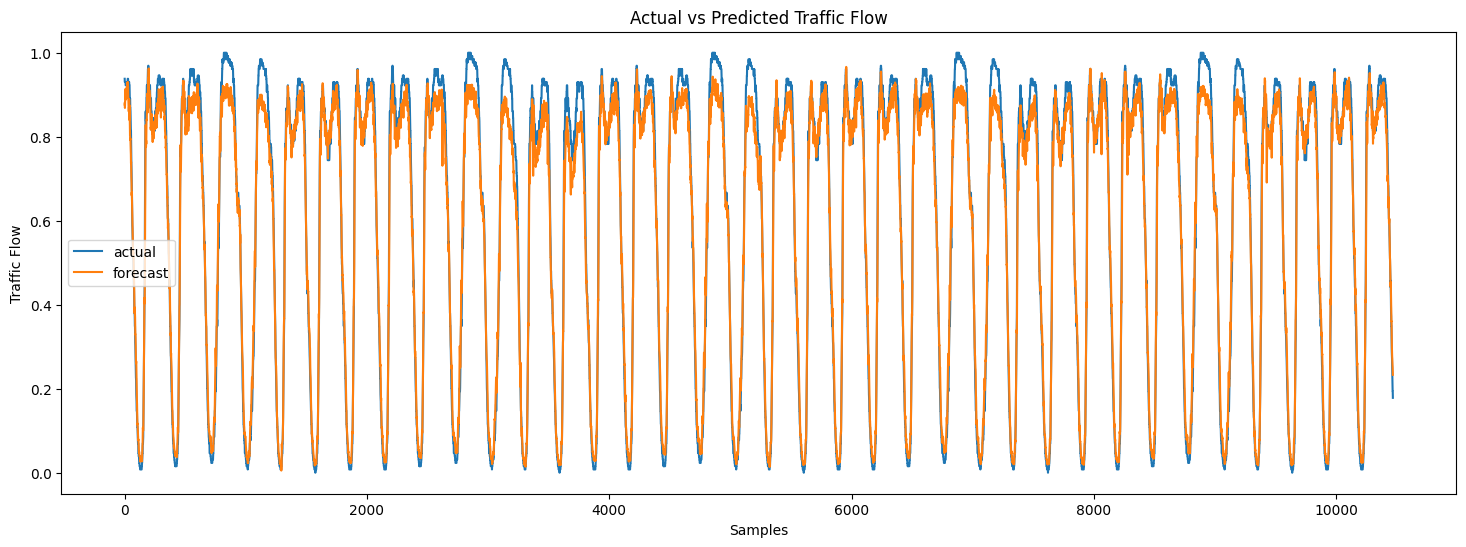

In [ ]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)

# Reshape y and y_pred to two-dimensional arrays
y_2d = np.reshape(y, (y.shape[0], -1))  # Shape: (10470, 315)
y_pred_2d = np.reshape(y_pred, (y_pred.shape[0], -1))  # Shape: (10470, 315)

plt.figure(figsize=(18, 6))
plt.plot(y_2d[:, 0])
plt.plot(y_pred_2d[:, 0])
plt.xlabel('Samples')
plt.ylabel('Traffic Flow')
plt.title('Actual vs Predicted Traffic Flow')
plt.legend(["actual", "forecast"])

# Evaluate model predictions using appropriate metrics
naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"Model MAE : {model_mse}")

# Calculate MAPE
model_mape = mean_absolute_percentage_error(y_pred_2d[:, 0], y_2d[:, 0])
print(f"model MAPE : {model_mape}")

# Calculate RMSE
model_rmse = np.sqrt(mean_squared_error(y_pred_2d[:, 0], y_2d[:, 0]))
print(f"Model RMSE : {model_rmse}")

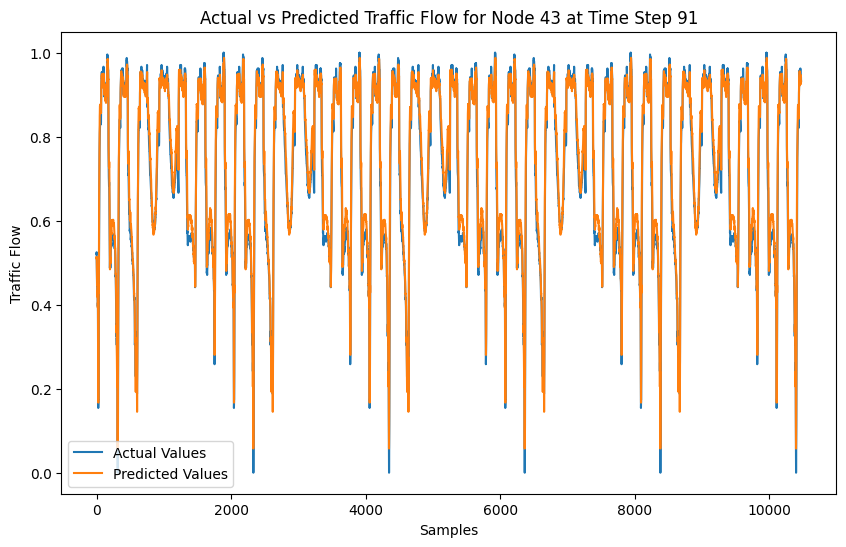

Node Index: 43
Time Step Index: 91
Actual Values: [0.52083333 0.52083333 0.525      ... 0.9375     0.94166667 0.93333333]
Predicted Values: [0.51252764 0.5091354  0.50957423 ... 0.92625266 0.9282531  0.9312997 ]


In [ ]:
# Select a random node index and time step index
node_index = np.random.randint(0, graph.num_nodes)
time_step_index = np.random.randint(0, 100)

# Get the actual and predicted values for the selected node and time step
actual_values = y_2d[:, node_index * forecast_horizon + time_step_index]
predicted_values = y_pred_2d[:, node_index * forecast_horizon + time_step_index]

# Plotting the actual vs predicted values for the selected node and time step
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Values')
plt.plot(predicted_values, label='Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Traffic Flow')
plt.title(f'Actual vs Predicted Traffic Flow for Node {node_index} at Time Step {time_step_index}')
plt.legend()
plt.show()

# Print the actual and predicted values for the selected node and time step
print("Node Index:", node_index)
print("Time Step Index:", time_step_index)
print("Actual Values:", actual_values)
print("Predicted Values:", predicted_values)
